In [1]:
# !pip3 install --upgrade torch --user
# !pip3 install torchvision --user

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn


from torchvision import datasets
from torchvision import transforms



In [2]:
class PatchLoader(torch.utils.data.Dataset):
    def __init__(self, clear_patch, noised_patch):
        self.clear_crops = torch.load(clear_patch)
        self.noised_crops = torch.load(noised_patch)
    def __len__(self):
        return len(self.noised_crops)
    def __getitem__(self, index):
        return self.clear_crops[index], self.noised_crops[index]

In [3]:
train_dataloader = torch.utils.data.DataLoader(PatchLoader('../Data/clear_crops.64.train.tensor', 
                                                           '../Data/noised_crops.64.train.tensor'),
                                               batch_size=32, num_workers=16)

val_dataloader = torch.utils.data.DataLoader(PatchLoader('../Data/clear_crops.64.val.tensor', 
                                                         '../Data/noised_crops.64.val.tensor'),
                                               batch_size=32, num_workers=16)


In [4]:
def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)


In [5]:
class GraphConv(nn.Module):
    def __init__(self, k, input_channels, out_channels, search_area=None):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, 1)
        self.conv2 = nn.Conv2d(input_channels, out_channels, 3, padding=1)
        self.conv3 = nn.Conv2d(input_channels, out_channels, 5, padding=2)
        
    def forward(self, x):
        return torch.mean(torch.stack([self.conv1(x),
                                       self.conv2(x),
                                       self.conv3(x)]), dim=0)

In [6]:
class PreProcessBlock(nn.Module):
    def __init__(self, input_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels, kernel_size,
                              padding=(kernel_size//2, kernel_size//2))
        self.activ = nn.LeakyReLU(0.05)
        self.bn = nn.BatchNorm2d(out_channels)
        
        self.GC = GraphConv(k, out_channels, out_channels) # out_channels -> out_channels
        
    def forward(self, x):
        x = self.activ(self.conv(x))
        x = self.GC(x)
        x = self.activ(self.bn(x))
        return x

In [7]:
class Residual(nn.Module):
    def __init__(self, k, input_channels, out_channels):
        super().__init__()
        self.pipeline = nn.Sequential(
            GraphConv(k, input_channels, input_channels),
            nn.BatchNorm2d(input_channels),
            nn.LeakyReLU(0.05),
            
            GraphConv(k, input_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.05),
            
            GraphConv(k, out_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.05),
        )
        
    def forward(self, x):
        return self.pipeline(x)

In [8]:
class PreProcessBlock(nn.Module):
    def __init__(self, k, kernel_size, input_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, out_channels, kernel_size,
                              padding=(kernel_size//2, kernel_size//2))
        self.activ = nn.LeakyReLU(0.05)
        self.bn = nn.BatchNorm2d(out_channels)
        
        self.GC = GraphConv(k, out_channels, out_channels) # out_channels -> out_channels
        
    def forward(self, x):
        x = self.activ(self.conv(x))
        x = self.GC(x)
        x = self.activ(self.bn(x))
        return x

In [9]:
loss_mse = nn.MSELoss()

class DNCNN(nn.Module):
    def __init__(self, k, input_channels, hidden_channels, patch_size=(64, 64)):
        super().__init__()
        self.patch_size = patch_size
        self.preprocessing_blocks = nn.ModuleList([
            PreProcessBlock(k, 3, input_channels, hidden_channels),
            PreProcessBlock(k, 5, input_channels, hidden_channels),
            PreProcessBlock(k, 7, input_channels, hidden_channels),
        ])
        self.residual_1 = Residual(k, hidden_channels*3, hidden_channels)
        self.residual_2 = Residual(k, hidden_channels, hidden_channels)
        
        self.GC = GraphConv(k, hidden_channels, input_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(hidden_channels*3, hidden_channels, 1),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.05),
            nn.Conv2d(hidden_channels, hidden_channels, 1),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.05),
        )
        
    def fit_image(self, image):
        processed_image = torch.cat([block(image) for block in self.preprocessing_blocks], dim=1)
        residual_1 = self.residual_1(processed_image)
        result_1 = residual_1 + self.downsample(processed_image)
        residual_2 = self.residual_2(result_1)
        result = residual_2 + result_1
        return [processed_image, residual_1, result, self.GC(result)]
    
    def forward(self, clear_image, noised_image):
        processed_image, residual_1, residual_2, answer = self.fit_image(clear_image)
        n_processed_image, n_residual_1, n_residual_2, n_answer = self.fit_image(noised_image)
        perceptual_loss = loss_mse(processed_image, n_processed_image) + \
            loss_mse(residual_1, n_residual_1) + \
            loss_mse(residual_2, n_residual_2)
        return n_answer, perceptual_loss
    
    def forward_eval(self, noised_image):
        _, _, _, answer = self.fit_image(noised_image)
        return answer

    
    def forward_image(self, noised_image, device, chunks=16):
        p_x, p_y = self.patch_size
        splits = torch.split(torch.stack(torch.split(noised_image, p_x)), p_y, dim=2)[:-1]
        crops = torch.stack(splits, dim=2)        
        crops = crops.view(-1, 1, p_x, p_y)
        crops_ = torch.split(crops, crops.shape[0]//chunks, dim=0)
        answer = torch.cat([crop + self.forward_eval(crop.cuda(device)).cpu().data for crop in crops_], dim=0)
        a_x, a_y = noised_image.shape
        return torch.clamp(answer, 0, 1).view(a_x, a_y - a_y%p_y)


In [10]:
from IPython.display import clear_output

In [11]:
gpu_num = get_freer_gpu()
device = torch.device('cuda:{}'.format(gpu_num))

device = torch.device('cuda:{}'.format(3))

device

device(type='cuda', index=3)

In [12]:
gpu_num

7

In [13]:
model = DNCNN(8, 1, 32, patch_size=(64, 64)).cuda(device)
optim = torch.optim.Adam(model.parameters())

In [14]:
loss_mse = nn.MSELoss()
losses = []
psnrs = []

MODEL_NAME = 'mc11_daq_CNN_64.valid'

In [15]:
def normalize(im):
    if im.max() == 0:
        return im
    return (im - im.min())/(im.max()-im.min())

In [16]:
def compute_psnr(image, noised):
    return 10 * np.log10(image.max().item()/loss_mse(image, noised).item())

In [17]:
def plot_diff(real, noised, denoised):
    plt.figure(figsize=(15, 15))
    
    for ind, im, noise, denoise in zip(range(1, 13, 3), real[:4], noised[:4], denoised[:4]):
        plt.subplot(4, 3, ind)
        plt.imshow(im)
        plt.yticks([])
        plt.xticks([])
        plt.title('Clear image')
        
        plt.subplot(4, 3, ind+1)
        plt.imshow(noise)
        plt.yticks([])
        plt.xticks([])
        plt.title('Noised image')
        
        plt.subplot(4, 3, ind+2)
        plt.imshow(denoise)
        plt.yticks([])
        plt.xticks([])
        plt.title('Denoised image')


    plt.show()

In [18]:
from tensorboardX import SummaryWriter
import torchvision.utils as vutils


writer = SummaryWriter('./TensorBoard/{}'.format(MODEL_NAME))

In [19]:
# val_images_clear =  torch.load('../Data/clear_events_collection_unnormalized_val.tensor')
# val_images_noised =  torch.load('../Data/noised_events_collection_unnormalized_val.tensor')

val_images_clear =  torch.load('../Data/clear_events_collection_unnormalized_val.tensor')
val_images_noised =  torch.load('../Data/noised_events_collection_unnormalized_val.tensor')

In [20]:
for epoch in tqdm.tqdm_notebook(range(100)):
    for train_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(train_dataloader, desc='Train loop', leave=False)):
        model.train()
        ind = epoch * len(train_dataloader) + train_ind
        optim.zero_grad()
        image, noise_image = image.cuda(device), noise_image.cuda(device)
        denoised_diff, perceptual_loss = model(image, noise_image)
        writer.add_scalar('train/perceptual_loss', perceptual_loss.item(), ind)
        denoise_image = denoised_diff + noise_image
        loss = loss_mse(image, denoise_image)
        writer.add_scalar('train/mse_loss', loss.item(), ind)
        loss = loss + perceptual_loss
        loss.backward()
        optim.step()
        writer.add_scalar('train/psnr', compute_psnr(image, denoise_image), ind)

    model.eval()
    losses, psnrs = [], []
    for val_ind, (image, noise_image) in enumerate(tqdm.tqdm_notebook(val_dataloader, desc='Test loop', leave=False)):
        image, noise_image = image.cuda(device), noise_image.cuda(device)
        denoised_diff, perceptual_loss = model(image, noise_image)
        denoise_image = denoised_diff + noise_image
        loss = loss_mse(image, denoise_image)
        loss = loss + perceptual_loss
        losses.append(loss.item())
        psnrs.append(compute_psnr(image, denoise_image))
    writer.add_scalar('val/psnr', np.mean(psnrs), ind)
    writer.add_scalar('val/combined_loss', np.mean(losses), ind)
    img_indexes = torch.randint(high=len(noise_image), size=(10,))
    dummy_img = torch.cat([image[img_indexes],
                           noise_image[img_indexes],
                           denoise_image[img_indexes]], dim=0).cpu().data
    x = vutils.make_grid(dummy_img, nrow=10)
    writer.add_image('val/crops', x, ind)

    img_index = torch.randint(high=len(val_images_clear), size=(1,))
    clear_image = normalize(val_images_clear[img_index])
    noised_image = normalize(val_images_noised[img_index])
    denoised_image = normalize(model.forward_image(noised_image.squeeze(0), device).cpu().data.unsqueeze(0))
    d_x, d_y = denoised_image.shape[-2:]
    writer.add_image('val/clear_image', clear_image[:, :d_x, :d_y], ind)
    writer.add_image('val/noised_image', noised_image[:, :d_x, :d_y], ind)
    writer.add_image('val/denoised_image', denoised_image[:, :d_x, :d_y], ind)            
            
            

In [21]:
torch.save(model, 'SavedModels/{}.model'.format(MODEL_NAME))
torch.save(model.state_dict(), 'SavedModels/{}.state_dict'.format(MODEL_NAME))


/afs/cern.ch/user/m/martemev/.local/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DNCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/afs/cern.ch/user/m/martemev/.local/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PreProcessBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/afs/cern.ch/user/m/martemev/.local/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GraphConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/afs/cern.ch/user/m/martemev/.local/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Residual. It won't be checked f

In [55]:
img_index = torch.randint(high=len(val_images_clear), size=(1,))
clear_image = normalize(val_images_clear[img_index]).squeeze(0)
noised_image = normalize(val_images_noised[img_index]).squeeze(0)


In [63]:
denoised_image = \
    model.forward_image(val_images_noised[img_index].squeeze(0), device).cpu().data.unsqueeze(0).squeeze(0)


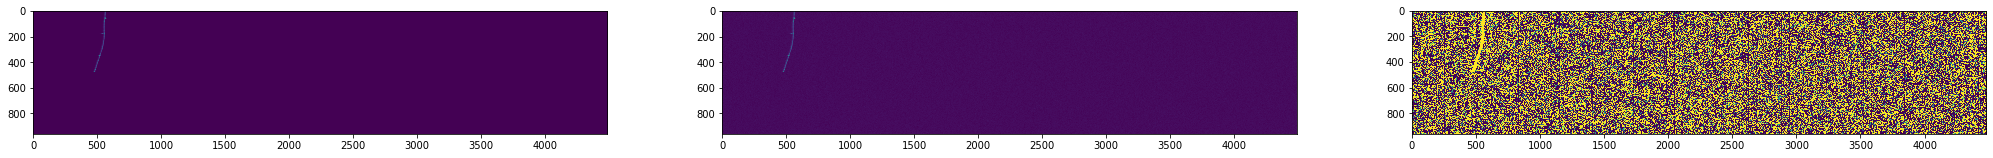

In [66]:
plt.figure(figsize=(35, 20))

plt.subplot(1, 3, 1)
plt.imshow(clear_image)
plt.subplot(1, 3, 2)
plt.imshow(noised_image)
plt.subplot(1, 3, 3)
plt.imshow(denoised_image)

plt.show()

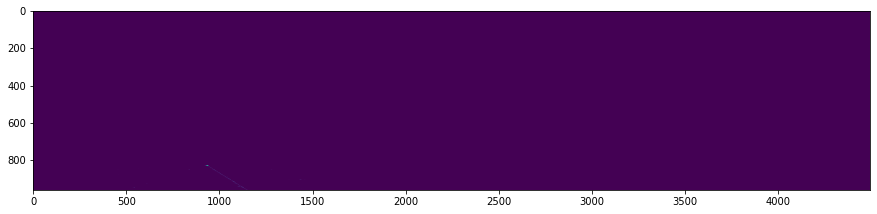

In [33]:
plt.figure(figsize=(15, 15))
plt.imshow(normalize(val_images_clear[0]))
plt.show()

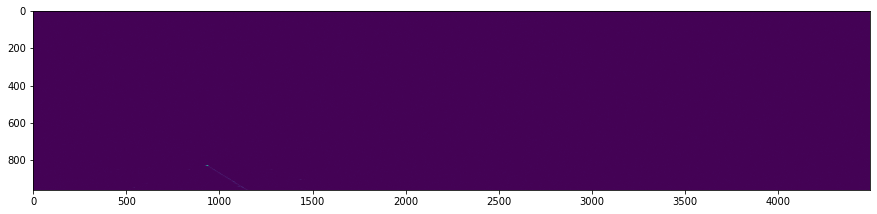

In [34]:
plt.figure(figsize=(15, 15))
plt.imshow(normalize(val_images_noised[0]))
plt.show()

In [ ]:
denoised_image = normalize(model.forward_image(val_images_noised[0].squeeze(0), device).cpu().data.unsqueeze(0))

In [ ]:
normalize(model.forward_image(noised_image.squeeze(0), device).cpu().data.unsqueeze(0))

In [35]:
noised_image.squeeze(0)

torch.Size([960, 4492])

In [37]:
val_images_noised[0].squeeze(0).shape

torch.Size([960, 4492])

In [39]:
val_images_noised[0].shape

torch.Size([960, 4492])